In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models  
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
import shutil  

from os.path import exists
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


#Loading and preparind data 

In [ ]:
#linking to the driver
from google.colab import drive
drive.mount('/content/gdrive')

MessageError: ignored

In [ ]:
# Getting the api josn file to download the data from kaggle (competition authorization)
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [ ]:
!kaggle datasets download -d kritika397/breast-cancer-dataset-from-breakhis

100% 7.96G/7.97G [03:03<00:00, 28.6MB/s]
100% 7.97G/7.97G [03:04<00:00, 46.5MB/s]


In [ ]:
!unzip -qq /content/breast-cancer-dataset-from-breakhis.zip

In [ ]:
directory_train = '/content/train'
directory_test = '/content/test'
if not (os.path.exists('/content/train') and os.path.exists('/content/test')): 
    os.makedirs('/content/train')
    os.makedirs('/content/test')
    os.makedirs('/content/train/B_400X')
    os.makedirs('/content/train/M_400X')
    os.makedirs('/content/test/B_400X')
    os.makedirs('/content/test/M_400X')

In [ ]:
test_data_B = os.listdir('/content/fold1/test/400X/B_400X')
test_data_M = os.listdir('/content/fold1/test/400X/M_400X')
train_data_B = os.listdir('/content/fold1/train/400X/B_400x')
train_data_M = os.listdir('/content/fold1/train/400X/M_400X')

In [ ]:
test_B_length=len(test_data_B)
print("test B" ,test_B_length)

test_M_length=len(test_data_M)
print("test M",test_M_length)

train_B_length=len(train_data_B)
print("train B",train_B_length) 

train_M_length=len(train_data_M)
print("train M",train_M_length) 

test B 237
test M 418
train B 351
train M 814


In [ ]:
#test_B
for i in range (0,100):
  shutil.copy(f'/content/fold1/test/400X/B_400X/{test_data_B[i]}' , '/content/test/B_400X')

#test_M
for i in range (0,100):
  shutil.copy(f'/content/fold1/test/400X/M_400X/{test_data_M[i]}' , '/content/test/M_400X')

#train_B
for i in train_data_B:
  shutil.copy(f'/content/fold1/train/400X/B_400x/{i}' , '/content/train/B_400X')

for i in range (101,len(test_data_B)):
  shutil.copy(f'/content/fold1/test/400X/B_400X/{test_data_B[i]}' , '/content/train/B_400X')
#train_M
for i in train_data_M:
  shutil.copy(f'/content/fold1/train/400X/M_400X/{i}' , '/content/train/M_400X')

for i in range (101,len(test_data_M)):
  shutil.copy(f'/content/fold1/test/400X/M_400X/{test_data_M[i]}' , '/content/train/M_400X')

In [ ]:
test_data_B2 = os.listdir('/content/test/B_400X')
test_data_M2 = os.listdir('/content/test/M_400X')
train_data_B2 = os.listdir('/content/train/B_400X')
train_data_M2 = os.listdir('/content/train/M_400X')

In [ ]:
test_B_length=len(test_data_B2)
print("test B" ,test_B_length)

test_M_length=len(test_data_M2)
print("test M",test_M_length)

train_B_length=len(train_data_B2)
print("train B",train_B_length) 

train_M_length=len(train_data_M2)
print("train M",train_M_length) 

test B 100
test M 100
train B 487
train M 1131


In [ ]:
data_dir = '/content/'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/test'
nThreads = 4
batch_size = 64
use_gpu = torch.cuda.is_available()

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import json
# make sure that the cat.json file not missing 
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.Resize(224),
        transforms.RandomResizedCrop(224),
        #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names= image_datasets['train'].classes

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

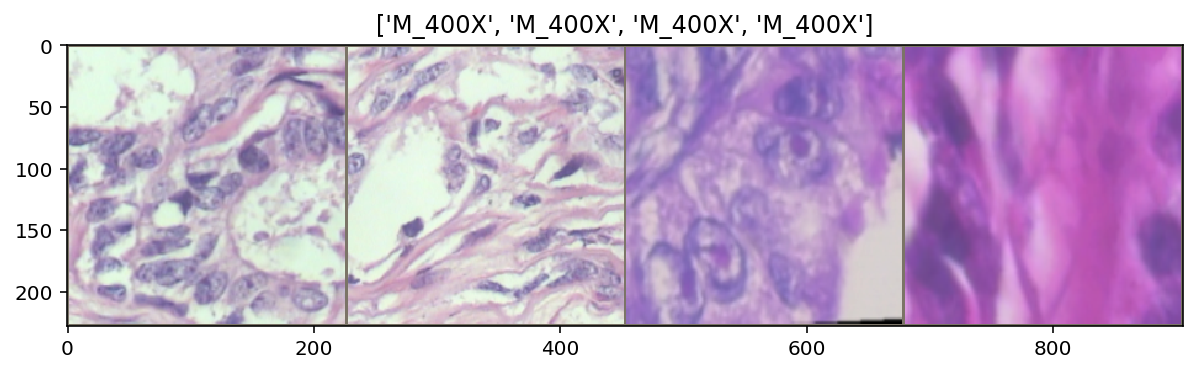

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(10, 10))
imshow(out, title=[class_names[x] for x in classes])

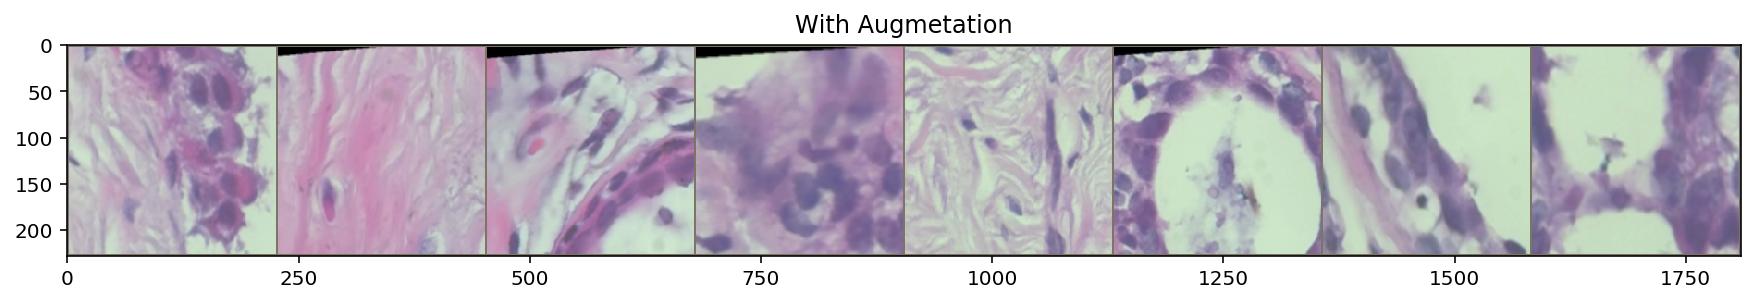

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [ ]:
# display the effect of Augmentation

data_Aug = torch.utils.data.DataLoader(datasets.ImageFolder(os.path.join(data_dir, 'train'),data_transforms['train']), 
                                       batch_size=8, shuffle=False, num_workers=2)

data_noAug = torch.utils.data.DataLoader(datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['test']), 
                                         batch_size=8, shuffle=False, num_workers=2)

# With Aug
inputs, classes = next(iter(data_Aug))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(15, 15))
imshow(out, title='With Augmetation')

# withought Aug
inputs, classes = next(iter(data_noAug))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(15, 15))

#Building & Training Classifier

In [ ]:
# Load resnet-50 pre-trained network
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
number_to_freeze = 0 #  number of layers to freeze
for i, param in enumerate(model.parameters()):
    if(i >= number_to_freeze): break
    param.requires_grad = False

In [ ]:
from collections import OrderedDict

# creating the classifier ordered dictionary first
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)), 
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(512, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# replacing the pretrained model classifier with our classifier
model.fc = classifier

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                
                # best accuracy wt checkpoint
                model.class_to_idx = dataloaders['train'].dataset.class_to_idx
                model.epochs = epoch
                checkpoint = {'input_size': [3, 244, 244],
                              'batch_size': dataloaders['train'].batch_size,
                              'output_size': 2,
                              'state_dict': model.state_dict(),
                              'data_transforms': data_transforms,
                              'optimizer_dict':optimizer.state_dict(),
                              'class_to_idx': model.class_to_idx,
                              'epoch': model.epochs}
                torch.save(checkpoint, '/content/gdrive/My Drive/result2/shalata_resnet50_100epochs_0ayersfreezed_bestscrore_checkpoint.pth')           
        
        #last epoch wt checkpoint
        model.class_to_idx = dataloaders['train'].dataset.class_to_idx
        model.epochs = epoch
        checkpoint = {'input_size': [3, 244, 244],
                      'batch_size': dataloaders['train'].batch_size,
                      'output_size':2,
                      'state_dict': model.state_dict(),
                      'data_transforms': data_transforms,
                      'optimizer_dict':optimizer.state_dict(),
                      'class_to_idx': model.class_to_idx,
                      'epoch': model.epochs}
        torch.save(checkpoint, '/content/gdrive/My Drive/result2/shalata_resnet50_100epochs_45ayersfreezed_lastscrore_checkpoint.pth')
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    checkpoint = torch.load('/content/gdrive/My Drive/result2/shalata_resnet50_100epochs_0ayersfreezed_bestscrore_checkpoint.pth')
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [ ]:
# Train a model with a pre-trained network
num_epochs = 100
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Adam optimizer with a learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=.0001)
# Optimizer = optim.SGD(model.fc.parameters(), lr = .1, momentum=0.9)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.55)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs)

Using GPU: True
Epoch 1/100
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.5108 Acc: 0.7540
test Loss: 0.5836 Acc: 0.6550

Epoch 2/100
----------
train Loss: 0.4712 Acc: 0.7855
test Loss: 0.4271 Acc: 0.7950

Epoch 3/100
----------
train Loss: 0.4577 Acc: 0.8022
test Loss: 0.4502 Acc: 0.8000

Epoch 4/100
----------
train Loss: 0.4351 Acc: 0.8103
test Loss: 0.4638 Acc: 0.7900

Epoch 5/100
----------
train Loss: 0.4239 Acc: 0.8047
test Loss: 0.3776 Acc: 0.8350

Epoch 6/100
----------
train Loss: 0.4069 Acc: 0.8245
test Loss: 0.4614 Acc: 0.8050

Epoch 7/100
----------
train Loss: 0.4155 Acc: 0.8171
test Loss: 0.4847 Acc: 0.7850

Epoch 8/100
----------
train Loss: 0.3999 Acc: 0.8208
test Loss: 0.5121 Acc: 0.7700

Epoch 9/100
----------
train Loss: 0.4111 Acc: 0.8257
test Loss: 0.4573 Acc: 0.7750

Epoch 10/100
----------
train Loss: 0.3948 Acc: 0.8276
test Loss: 0.4400 Acc: 0.8000

Epoch 11/100
----------
train Loss: 0.3982 Acc: 0.8226
test Loss: 0.4385 Acc: 0.8100

Epoch 12/100
----------
train Loss: 0.4050 Acc: 0.8220
test Loss: 0.3907 Acc: 0.8100



#loading checkpoint 

In [ ]:
def load_checkpoint(filepath):
    """ a function that loads a checkpoint and rebuilds the model """
    checkpoint = torch.load(filepath)
    model = models.resnet50()
    
    # our input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 2
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(512, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))


    # replacing the pretrained model classifier with our classifier
    model.fc = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# get index to class mapping
loaded_model, class_to_idx = load_checkpoint('/content/gdrive/My Drive/result2/shalata_resnet50_100epochs_0ayersfreezed_bestscrore_checkpoint.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

#*Prediction*

In [ ]:
def predict(image_path, model , transform) :
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    image = transform(Image.open(image_path)).unsqueeze(0)
    model.eval()
    output = model.forward(Variable(image))
    probabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(probabilities)[-3:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = probabilities[top_idx]

    return top_idx , top_probability, top_class

#Displaying 

In [ ]:
# Display an image along with the top 3 classes
def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    if img_filename == 'B_400X' :
      img_filename = 'benigno'
    else: 
      img_filename = 'maligno'

    fig, (ax1, ax2) = plt.subplots(figsize=(7,11), ncols=1, nrows=2) 
    driver_type = mapper[img_filename]
    
    ax1.set_title(driver_type)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(classes)
    ax2.invert_yaxis()
  

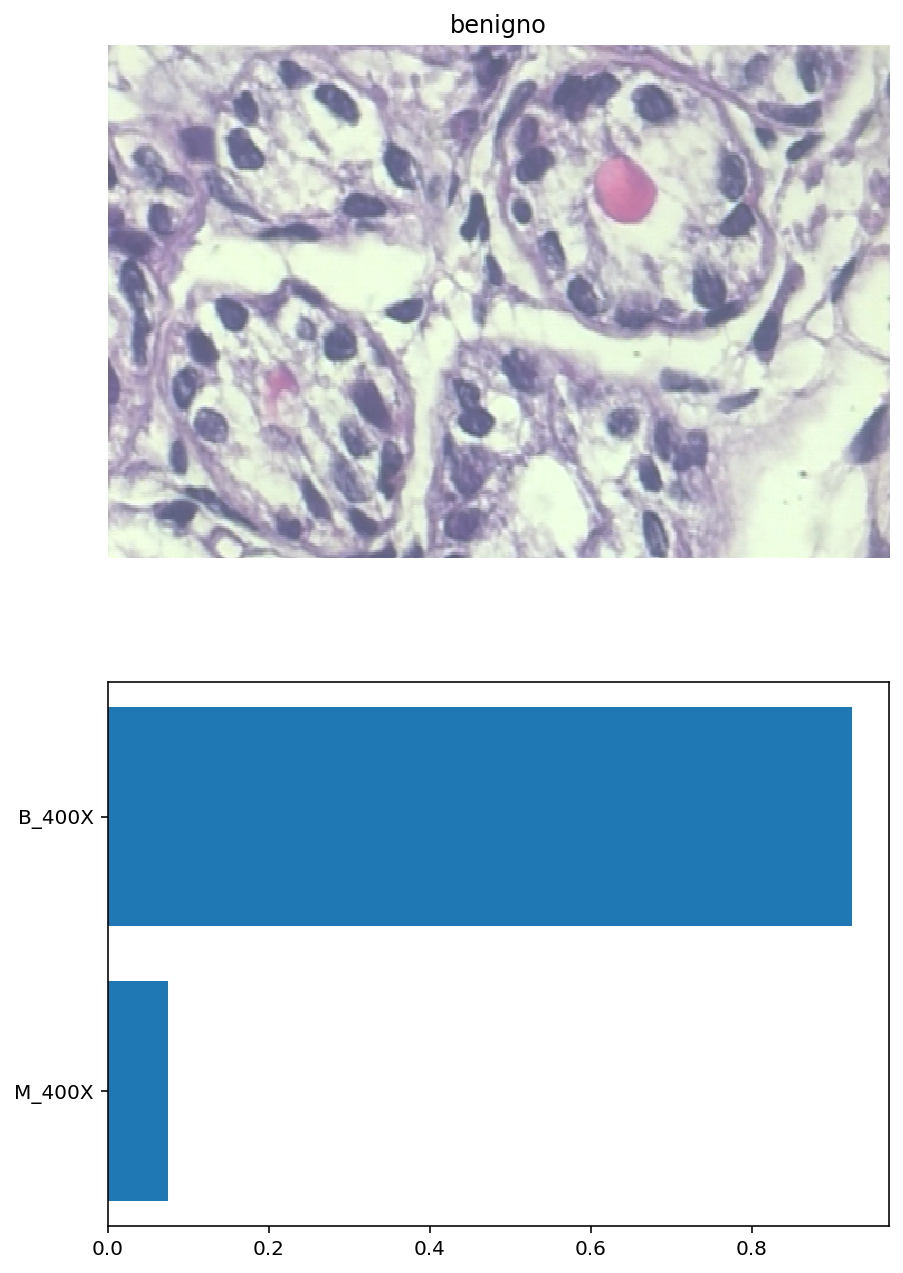

In [ ]:
img ='/content/test/B_400X/SOB_B_F-14-9133-400-008.png'
_ , p, c = predict(img, loaded_model , data_transforms['test'])
c = view_classify(img, p, c, cat_to_name)

#*model evaluation* 

In [ ]:
# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
    
  for images, labels in dataloaders['test']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
     
  print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))

In [ ]:
test(loaded_model, dataloaders, device)

Testing Accuracy: 0.855


In [ ]:
y_pred = []
y_true = []

loaded_model.eval()
accuracy = 0

loaded_model.to(device)
  
for images, labels in dataloaders['test']:
  images = Variable(images)
  labels = Variable(labels)
  images, labels = images.to(device), labels.to(device)
    
  output = loaded_model.forward(images)
  ps = torch.exp(output)
  pred = ps.max(1)[1]
  y_pred.extend(pred.cpu().numpy())
  y_true.extend(labels.cpu().numpy())
  
print(y_pred)
print(y_true)

[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,

In [ ]:
from sklearn.metrics import recall_score , f1_score ,precision_score
print(' recall is : ' , recall_score (y_true, y_pred, average='macro'))
print(' precision is : ' , precision_score(y_true, y_pred, average='macro'))
print(' f1 Score is : ' , f1_score(y_true, y_pred, average='macro') )

 recall is :  0.855
 precision is :  0.8611026345234463
 f1 Score is :  0.8543847756772363


In [ ]:
nb_classes = 2
confusion_matrix = torch.zeros(nb_classes , nb_classes)
with torch.no_grad():
  for i , (inputs,classes) in enumerate(dataloaders['test']):
    inputs = inputs.to(device) 
    classes = classes.to(device) 
    loaded_model.to(device)
    outputs = loaded_model(inputs)
    _ , preds = torch.max(outputs , 1 )
    for t,p in zip(classes.view(-1) , preds.view(-1)):
      confusion_matrix[t.long() , p.long()] +=1

print(confusion_matrix) 

tensor([[79., 21.],
        [ 8., 92.]])


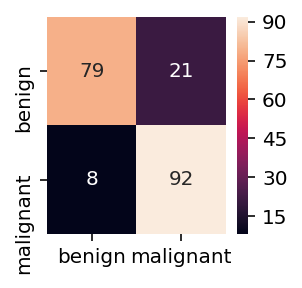

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix.cpu().numpy() 
df_cm = pd.DataFrame(array, index =  ['benign','malignant'],
                  columns = ['benign','malignant'])
plt.figure(figsize = (2,2))
sn.heatmap(df_cm, annot=True)